# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Импорт библиотек

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import lightgbm as lgb

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    PolynomialFeatures
)
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

### Импорт и изучение данных

In [22]:
data = pd.read_csv(r"C:\autos.csv")
data.head()

In [23]:
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in data.columns]
data.head()

### Заполнение пропущенных значений и обработка аномалий в столбцах. Удаление неинформативных признаков.

In [24]:
data.info()

Необходимо создать модель определения цены подержанного автомобиля исходя из его технических характеристик, комплектации и исходной цены. Удалим неинформативные признаки 'date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'.  

In [25]:
data = data.drop(['date_crawled', 'registration_month', 'date_created',\
                  'number_of_pictures', 'postal_code', 'last_seen'], axis=1)

data.head()

Определим дубликаты и удажим их.

In [26]:
data.duplicated().sum()

In [27]:
data = data.drop_duplicates()
data.duplicated().sum()

In [28]:
data.info()

In [29]:
data.describe()

Нужно определить и обработать аномальные значения

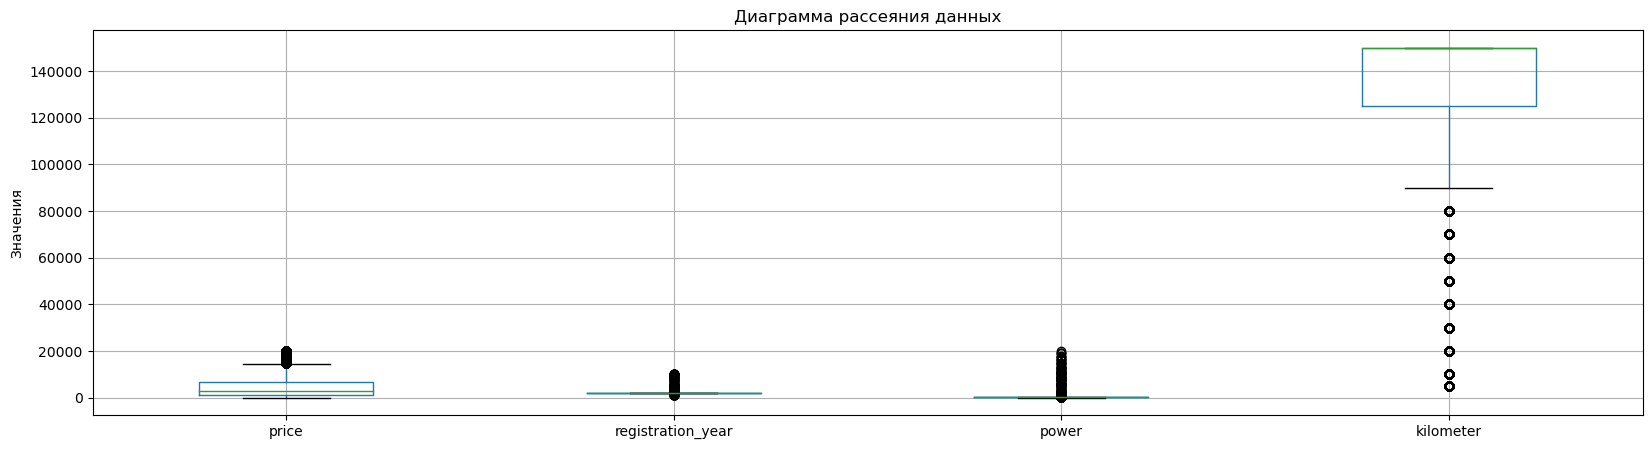

In [30]:
data[['price', 'registration_year', 'power', 'kilometer']].boxplot(figsize=(20,5))
plt.title('Диаграмма рассеяния данных')
plt.ylabel('Значения')
plt.show()

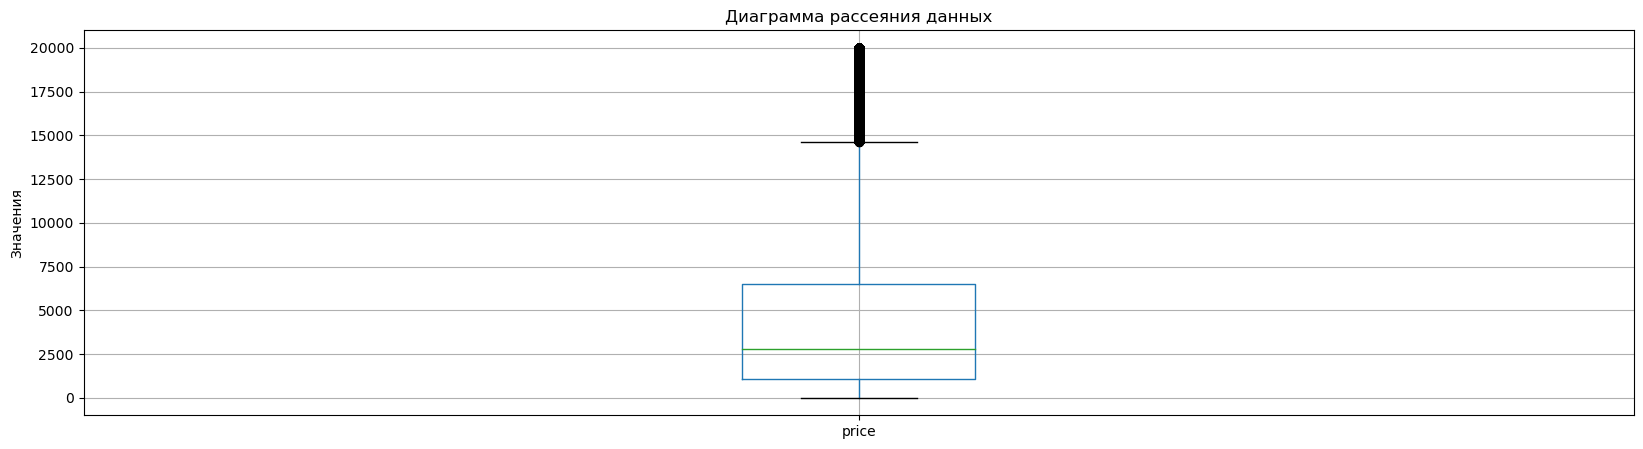

In [31]:
data[['price']].boxplot(figsize=(20,5))
plt.title('Диаграмма рассеяния данных')
plt.ylabel('Значения')
plt.show()

In [32]:
data[data['price']==0]

Цена не может быть нулевой. Данные строки необходимо удалить

In [33]:
data = data[data['price']>0]
data[data['price']==0]['power'].sum()

In [34]:
data[data['price']<100]

In [35]:
data.info()

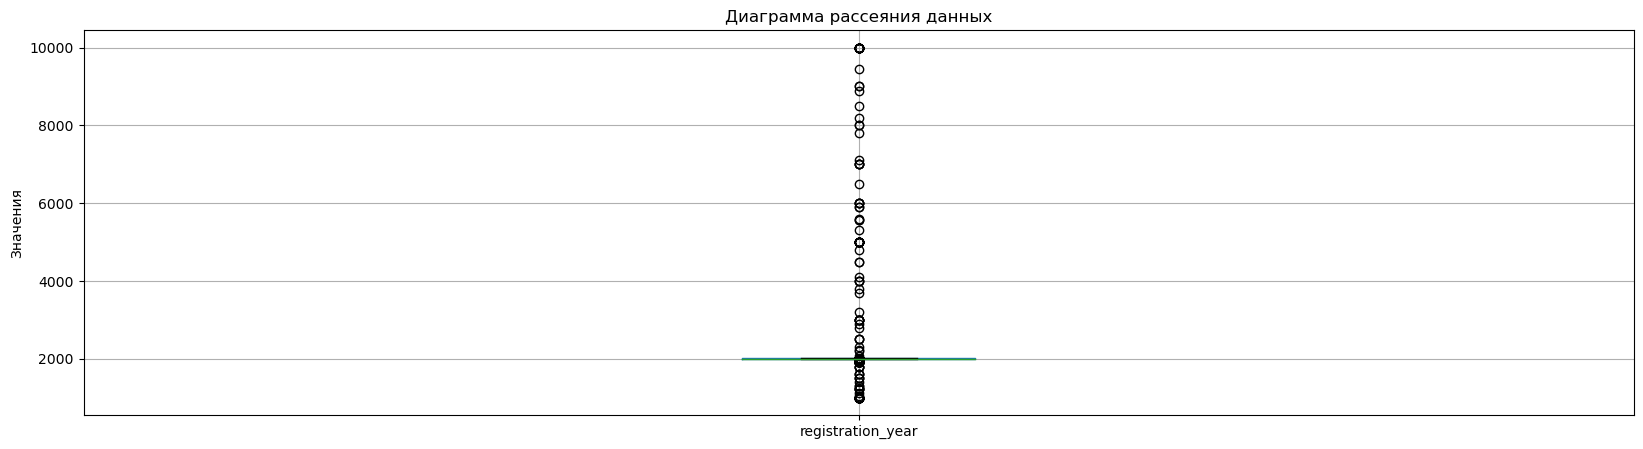

In [36]:
data[['registration_year']].boxplot(figsize=(20,5))
plt.title('Диаграмма рассеяния данных')
plt.ylabel('Значения')
plt.show()

Удалим некорректные данные по году регистрации

In [37]:
data[data['registration_year']<1900]

In [38]:
data = data[data['registration_year']>1900]

In [39]:
data[data['registration_year']>2016]

In [40]:
data = data[data['registration_year']<2017]

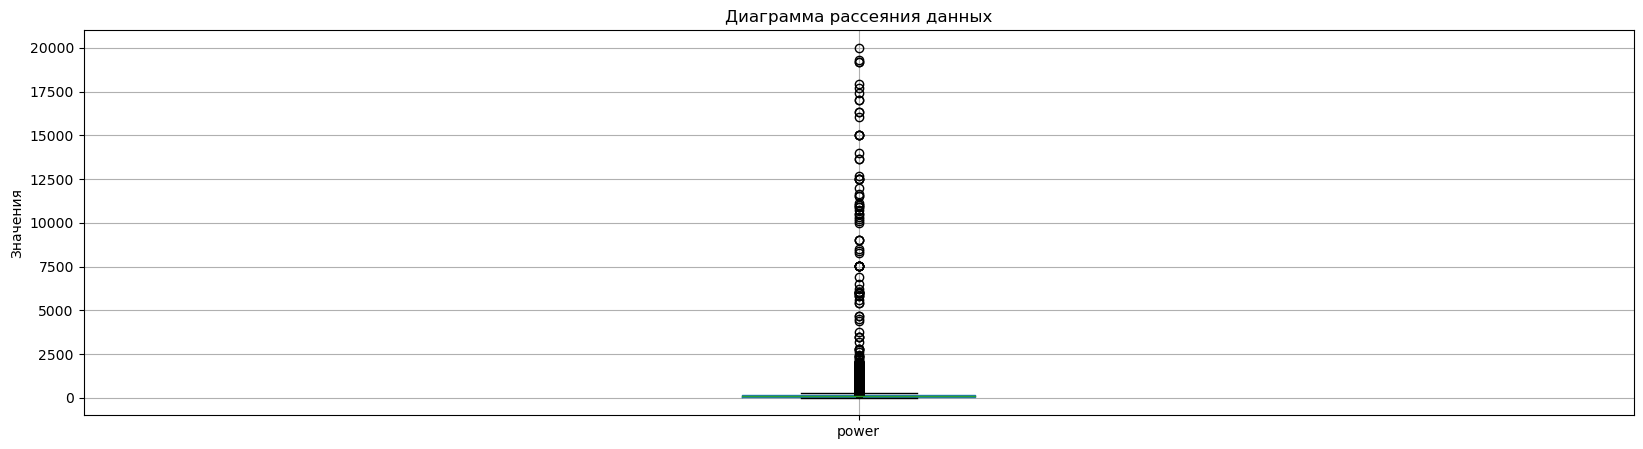

In [41]:
data[['power']].boxplot(figsize=(20,5))
plt.title('Диаграмма рассеяния данных')
plt.ylabel('Значения')
plt.show()

Самый мощный автомобиль имеет мощность в районе 1600 л.с., поэтому все авто выше этого значения некорректны. Также мощность равная нулю тоже некорректна.

In [42]:
data[data['power']==0]

In [43]:
data[data['power']>1600]

In [44]:
data = data[data['power']>0]
data = data[data['power']<1600]

In [45]:
data.info()

In [46]:
data['vehicle_type'].unique()

In [47]:
data['gearbox'].unique()

In [48]:
data['model'].unique()

In [49]:
data['fuel_type'].unique()

In [50]:
data['brand'].unique()

In [51]:
data['repaired'].unique()

In [52]:
data.isna().agg(['sum', 'mean'])

Пропущенных данных достаточно много. Заполним данные.

In [53]:
data['vehicle_type'] = data['vehicle_type'].fillna('other')
data['gearbox'] = data['gearbox'].fillna('no_inf')
data['model'] = data['model'].fillna('other')
data['fuel_type'] = data['fuel_type'].fillna('other')
data['repaired'] = data['repaired'].fillna('no_inf')

In [54]:
data.isna().agg(['sum', 'mean'])

'gasoline' и 'petrol' это одно и тоже, поэтому приведем к одному имени.

In [55]:
def fuel_change(row):
    try: 
        if row=='gasoline':
            return row.replace('gasoline', 'petrol')
        else:
            return row
    except:
        pass
data['fuel_type'] = data['fuel_type'].apply(fuel_change)

In [56]:
data['fuel_type'].unique()

In [57]:
data.info()

Предобработка данных завершена

## Обучение моделей

Подготовьте выборки для обучения моделей.

In [58]:
features = data.drop('price', axis=1)
target = data['price']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

print(features_train.shape)
print(features_test.shape)

print(target_train.shape)
print(target_test.shape)


### Поиск гиперпараметров для моделей

#### Первая модель

In [59]:
cat_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired' ]
num_columns = ['registration_year', 'power', 'kilometer']

In [60]:
scaler = StandardScaler()
poly = PolynomialFeatures()

oh_encoder = OneHotEncoder(sparse=False, handle_unknown = 'ignore')

num_pipeline = make_pipeline(scaler, poly)


column_transformer = make_column_transformer((num_pipeline, num_columns),
                                             (oh_encoder, cat_columns),
                                             remainder='passthrough')
column_transformer

In [61]:
pipeline = Pipeline([('transformer', column_transformer),
                     ('model', LinearRegression())])
pipeline

In [62]:
# Создаем пространство признаков для перебора RandomizedSearchCV из соответствующего расспределения
estimators_range = [x for x in range(2, 20, 3)]
max_depth_range = [x for x in range(20, 200, 30)]

In [63]:
params = [{
    'model': [LinearRegression()],  
    },
        
    
    {
        'model': [RandomForestRegressor(random_state=12345)],
        'model__n_estimators': estimators_range,
        'model__max_depth': max_depth_range,
         },

    {
        'model': [DecisionTreeRegressor(random_state=12345)],
        'model__max_depth': max_depth_range,
            }

]


In [64]:
grid = RandomizedSearchCV(pipeline,
                    params,
                    cv=5,
                    verbose=1,
                    random_state=12345,
                    scoring='neg_root_mean_squared_error',
                    n_jobs=-1)

In [65]:
%%time
grid.fit(features_train, target_train)

In [66]:
grid.best_params_

In [67]:
abs(grid.best_score_)

#### Вторая модель

In [68]:
for c in cat_columns:
    features_train[c] = features_train[c].astype('category')
    features_test[c] = features_test[c].astype('category')

In [69]:
estimators_range = [x for x in range(2, 20, 3)]



# other scikit-learn modules
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [x for x in range(2, 20, 3)]
}

gbm = GridSearchCV(estimator, param_grid, cv=5, scoring='neg_root_mean_squared_error')


In [70]:
%%time
gbm.fit(features_train, target_train)

print(f'Best parameters found by grid search are: {gbm.best_params_}')

In [71]:
print(f'The RMSE of prediction is: {abs(gbm.best_score_)}')

#### Третья модель

In [72]:
%%time
model = CatBoostRegressor(loss_function='RMSE', iterations=50)
model.fit(features_train, target_train, cat_features = cat_columns, verbose=5)
print(f'The RMSE of prediction is: {model.best_score_}')

### Расчет точности и времени предсказания моделей

#### Первая модель

In [73]:
%%time
pipeline_grid = Pipeline([('transformer', column_transformer),
                     ('model', RandomForestRegressor(max_depth=110, n_estimators=17, random_state=12345))])
pipeline_grid.fit(features_train, target_train)

In [74]:
%%time
pred_pipeline_grid = pipeline_grid.predict(features_test)
print(f'The RMSE of prediction is:', mean_squared_error(target_test, pred_pipeline_grid, squared=False))

#### Вторая модель

In [75]:
%%time
gbm_test = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=1,
                        n_estimators=17)
gbm_test.fit(features_train, target_train)

In [76]:
%%time
pred_gbm_test = gbm_test.predict(features_test)
print(f'The RMSE of prediction is:', mean_squared_error(target_test, pred_gbm_test, squared=False))

#### Третья модель

In [77]:
%%time
cat_test = CatBoostRegressor(loss_function='RMSE', iterations = 50)
cat_test.fit(features_train, target_train, cat_features = cat_columns, verbose=5)

In [78]:
%%time
pred_cat_test = cat_test.predict(features_test)
print(f'The RMSE of prediction is:', mean_squared_error(target_test, pred_cat_test, squared=False))

## Анализ моделей

   1 модель - RandomForestRegressor.
    Скорость обучения - 1min 52s
    Скорость предсказания - 886 ms
    Точность - The RMSE of prediction is: 1704.484
    
   2 модель - lgb.LGBMRegressor.
    Скорость обучения - 238 ms
    Скорость предсказания - 36.9 ms
    Точность - The RMSE of prediction is: 1808.067
    
   3 модель -  CatBoostRegressor.
    Скорость обучения - 2.51 s
    Скорость предсказания - 36.8 ms
    Точность - The RMSE of prediction is: 1759.313   

## ВЫВОД: 
1. Проведен импорт и изучение данных.
2. Проведена предобработка данных. В том числе, удалены неинформативные признаки, дубликаты, проведен поиск неявных дубликатов и проведена их замена, удалены некорректные данные и выполнена работа с пропусками.
3. Выполнена подготовка выборок для поиска гиперпараметров моделей.
4. Рассмотрено 3 варианта моделей, причем одна модель не относится к бустингу.
5. Определены гиперпараметры моделей.
6. Произведен расчет времени обучения и предсказания моделей и определена их точность.
7. Наиболее быстро обучается модель LGBMRegressor. Быстрее всех предсказывает CatBoostRegressor. Точнее всех RandomForestRegressor.
8. Наиболее эффективной моделью по совокупности факторов является CatBoostRegressor. Данная модель быстрее всех моделей предсказывает с высокой точностью.